# Import of useful libraries

In [2]:
import numpy as np
import pandas as pd
import re
import string
import emoji
import warnings
from langid.langid import LanguageIdentifier, model
import matplotlib.pyplot as plt
import wordcloud as wc


# Import of data

In [3]:
tweets=pd.read_csv('cyberbullying_tweets.csv')
tweets_original=tweets.copy()

## Removal: 

Links convey no additional meaning to our tweets and often add a lot of noise - we can just remove them. The same applies to mentions and emoticons made with letters; moreover, another thing to remove is the "RT" letters that indicate the tweet itself was a retweet of someone else's tweet.

In [4]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub('http\S+|www\.\S+|\b\w+\.(com|org|net|io|edu|gov|us|uk)\b', '', x))

In [5]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub(r'@\w+', '', x))

In [6]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub(r'[:;=8][-~]?[)DPOp\*\(\]/\\|]', '', x))

In [7]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: x.replace("RT : ", ""))

Another type of removal is removing hastags symbols. This most often is correct because people both "insert" hastags between tweet words (such as "I love #pizza") and hence we want to preserve meaning. In cases where the hastags are instead at the end of the sentence (like "I love pizza #food #vlog"), still they add little noise to the meaning of the sentence! As such we decided to remove the # symbol and for good measure store any hastag in a dedicated column

In [8]:
def not_hastags_finder(text):
    non_hashtag_text = re.findall(r"(?<!#)\b(?:[^\s#]+(?:\s[^\s#]+)*)", text)
    result = " ".join(non_hashtag_text)
    return result

In [9]:
warnings.filterwarnings('ignore')
tweets['hastags']=tweets['tweet_text'].apply(lambda x: re.findall(r"#\w+", x))
tweets['text']=tweets['tweet_text'].apply(not_hastags_finder)

## Substitution

One thing to susbtitute are html tags (such as &amp, &gt)

In [10]:
tweets['tweet_text']=tweets['tweet_text'].apply(lambda x: x.replace('&amp;', 'and').replace("&lt;", "<").replace("&gt;", ">"))

## Language

We first start by removing now-empty tweets and some initial punctuations/Whitespaces to make things clearer: 

In [11]:
tweets = tweets[tweets['tweet_text'].str.strip()!='']

In [12]:
tweets['tweet_text'] = tweets['tweet_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [13]:
tweets['tweet_text']=tweets['tweet_text'].apply(lambda x: re.sub(r'^[;:!]+', '', x))

Another problem to tackle is that many tweets are not in english, or are partly in english. Some even are not with latin letters! As such, we want to try and check whether a given tweet is in english indeed. We can use the langid library for this purpose as a reference: 

In [14]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
tweets['language'] = tweets['text'].apply(lambda x: identifier.classify(x)[0]) 

Now, langid is not something that never fails; as such, it's best to try and correct false positives and false negatives from its classification. One approach is to check whether every word within the tweet is a valid word of the english language, given a word.txt vocabulary (from https://github.com/dwyl/english-words). We also first define two functions that will be useful both now and later on to continue with the processing:  

In [15]:
def remove_punctuations(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree
def remove_emojis(text):
    return ''.join(c for c in text if c not in emoji.EMOJI_DATA) 

In [16]:
with open('words.txt', 'r') as f:
    custom_words = set(f.read().splitlines())
import warnings
warnings.filterwarnings('ignore')

english_words=[element.lower() for element in custom_words] # we should ignore lowercase or uppercase

tweets_not_en=tweets[tweets['language']!='en'] # only looking for false negatives -> no need to scan the whole dataset

tweets_not_en.reset_index(inplace=True)
tweets_not_en['text']=tweets_not_en['text'].apply(remove_emojis)
tweets_not_en['text']=tweets_not_en['text'].apply(remove_punctuations)

tweets_not_en['secondary_check']=0 # we set it to 0 thiking no tweet is in English, then we'll change to one if we find it's made up of english words
for i in range(len(tweets_not_en)):
    k=1
    for word in remove_punctuations(tweets_not_en['text'][i]).lower().split():
        if word.lower() not in english_words:
            break
        k+=1
    
    if k==len(tweets_not_en['text'][i].split()): # here we are using k as check for the length of tweets in a word: 
        # this is because if k is the length of words in a tweet then every word did not trigger the if statement and hence the tweet is entirely 
        # composed of english words
        tweets_not_en['secondary_check'][i]=1 

In [17]:
to_change=tweets_not_en['index'][tweets_not_en['secondary_check']==1].values # these are indices values of tweets that were false negatives

In [18]:
warnings.filterwarnings('ignore')
for i in range(len(to_change)):
    tweets['language'][to_change[i]]='en'

We now don't care anymore about any non-english tweet that is still not in english, because we have no other way of recovering false negatives. As such we drop the remaining non-english tweets: 

In [19]:
tweets.drop(tweets[tweets['language']!='en'].index, inplace=True)

In [20]:
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)

## More removal/substitution

Now that the language is taken care of we can substitute emojis and currencies into literal words:

In [21]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: emoji.demojize(x).replace('_', ' ').replace(':', ' '))

In [22]:
tweets['tweet_text']= tweets['tweet_text'].apply(lambda x: x.replace('$', ' dollar ').replace('€', ' euro ').replace('£', ' pound '))

And we can also remove numbers and then proceed to remove again remaining punctuations, whitespaces and empty sentences:

In [23]:
tweets['tweet_text']= tweets['tweet_text'].apply(lambda x: re.sub(r'\d+', '', x))

In [24]:
def remove_punctuations(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation+'…'+'ð'+'\\'+'•'])
    return punctuationfree

tweets['tweet_text'] = tweets['tweet_text'].apply(remove_punctuations)

In [25]:
tweets['tweet_text'] = tweets['tweet_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [26]:
tweets = tweets[tweets['tweet_text'].str.strip()!='']

Last but not least we remove lowercase letter

In [27]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: x.lower())

In [28]:
tweets.reset_index(inplace=True)
tweets.drop('index', inplace=True, axis=1)

## Non-latin characters

We now tackle the problem of false positives within the langid classification. We do not want to have non latin characters to classify and turn into numbers; as such, we can look for any tweet with non latin characters and delete them.

In [29]:
warnings.filterwarnings('ignore')
tweets['cleantext']=0
for i in range(len(tweets)):

    tweets['cleantext'][i]=tweets['tweet_text'][i] # first we copy the tweet text in a new column

    for word in tweets['tweet_text'][i]: 
        
        if bool(re.fullmatch(r'[a-z\s]', word))==False:
            
            tweets['cleantext'][i]=tweets['cleantext'][i].replace(word, '') # any time we find that any word has a noneng character we remove it from the clean text column

Now we can remove additional whitespaces and empty tweets (again) caused byt our preprocessing

In [30]:
tweets['cleantext'] = tweets['cleantext'].str.replace(r'\s+', ' ', regex=True).str.strip() 

In [31]:
tweets.drop(tweets[tweets['cleantext']==''].index, inplace=True)
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)

In [32]:
tweets

,tweet_text,cyberbullying_type,hastags,text,language,cleantext
0,in other words katandandre your food was crapi...,not_cyberbullying,"[#katandandre, #mkr]","In other words , your food was crapilicious!",en,in other words katandandre your food was crapi...
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying,"[#aussietv, #MKR, #theblock, #ImACelebrityAU, ...",Why is so white?,en,why is aussietv so white mkr theblock imaceleb...
2,a classy whore or more red velvet cupcakes,not_cyberbullying,[],a classy whore? Or more red velvet cupcakes?,en,a classy whore or more red velvet cupcakes
3,meh thanks for the heads up but not too concer...,not_cyberbullying,[],"meh. thanks for the heads up, but not too conc...",en,meh thanks for the heads up but not too concer...
4,this is an isis account pretending to be a kur...,not_cyberbullying,[],This is an ISIS account pretending to be a Kur...,en,this is an isis account pretending to be a kur...
...,...,...,...,...,...,...
45363,black ppl arent expected to do anything depend...,ethnicity,[],"Black ppl aren't expected to do anything, depe...",en,black ppl arent expected to do anything depend...
45364,turner did not withhold his disappointment tur...,ethnicity,[],Turner did not withhold his disappointment. Tu...,en,turner did not withhold his disappointment tur...
45365,i swear to god this dumb nigger bitch i have g...,ethnicity,[],I swear to God. This dumb nigger bitch. I have...,en,i swear to god this dumb nigger bitch i have g...
45366,yea fuck you if youre a nigger fucking unfollo...,ethnicity,[],Yea fuck you IF YOURE A NIGGER FUCKING UNFOLLO...,en,yea fuck you if youre a nigger fucking unfollo...


At last we can remove the language column assuming all tweets we have are finally in english

In [33]:
tweets.drop('language', axis=1, inplace=True)

## Some Exploratory Analysis

We start by seeing how our dataset has changed: more specifically we can plot the distribution of cyberbullying classes after the processing

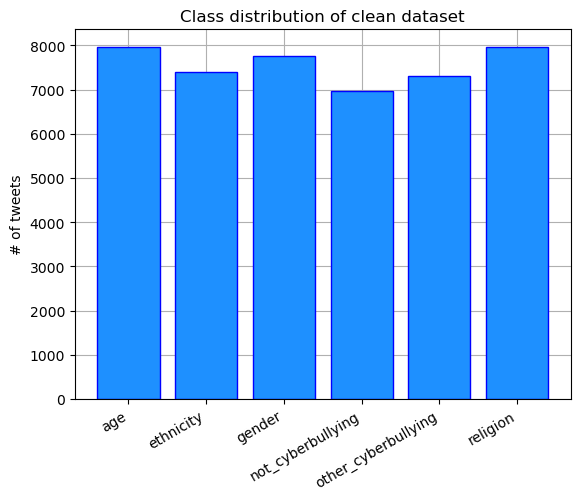

In [318]:
count=tweets.groupby('cyberbullying_type').count()['cleantext']
plt.bar(count.index, count.values, color='dodgerblue', edgecolor='blue', zorder=2)
plt.grid(visible=True, zorder=1)
plt.xticks(rotation=30, ha='right')
plt.title('Class distribution of clean dataset')
plt.ylabel('# of tweets')
plt.show()


To highlight all "lost" data from the original dataset we can also visualize the difference of tweets count by class of cyberbullying: 

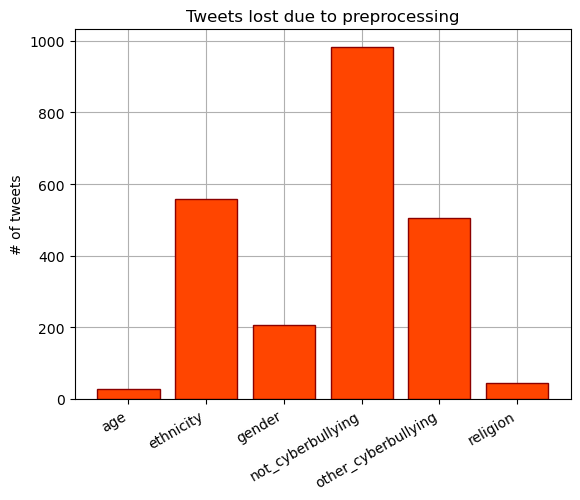

In [319]:
count=tweets_original.groupby('cyberbullying_type').count()['tweet_text']-tweets.groupby('cyberbullying_type').count()['cleantext']
plt.bar(count.index, count.values, color='orangered', edgecolor='darkred', zorder=2)
plt.xticks(rotation=30, ha='right')
plt.title('Tweets lost due to preprocessing')
plt.grid(zorder=1)
plt.ylabel('# of tweets')
plt.show()

This means unfortunately that we have introduced some imbalancing within our classes. To justify the choice of estimators and address this problem we have to compute some measure of how actually imbalanced is the dataset; in fact, we see that the imbalance seems low, but is it low enough, can we use standard accuracy as our measure for classification? Or do we have to use as target estimators ones that take into account a class imbalance, such as the Matthews Correlation Coefficient? 

To answer this we chose to compute the IR Index for our dataset's classes, which is just the ratio of most frequent to least frequent class

In [320]:
IR=max(tweets.groupby('cyberbullying_type').count()['cleantext'].values)/min(tweets.groupby('cyberbullying_type').count()['cleantext'].values)
IR

np.float64(1.1440677966101696)

We see an IR of one as a perfect balance; hence we have a slight imbalance, because our IR is quite close to 1. This means our imbalance is not too worrysome and will not affect our analysis

We can also try and see how long our tweets are: 

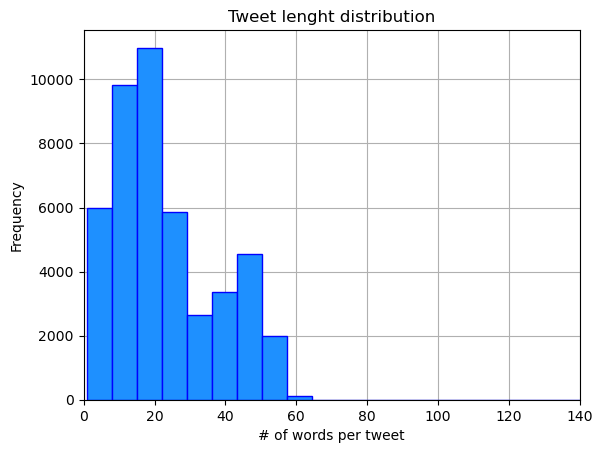

In [321]:
lenghts=[]
for i in range(len(tweets)): 
    lenghts.append(len(tweets['cleantext'][i].split(' ')))
plt.hist(lenghts, bins=100, color='dodgerblue', edgecolor='blue', zorder=2)
plt.grid(zorder=1)
plt.xlim(0, 140)
plt.title('Tweet lenght distribution')
plt.xlabel('# of words per tweet')
plt.ylabel('Frequency')
plt.show()

Lastly, we'll take a look at a simple wordcloud for all cyberbullying categories:

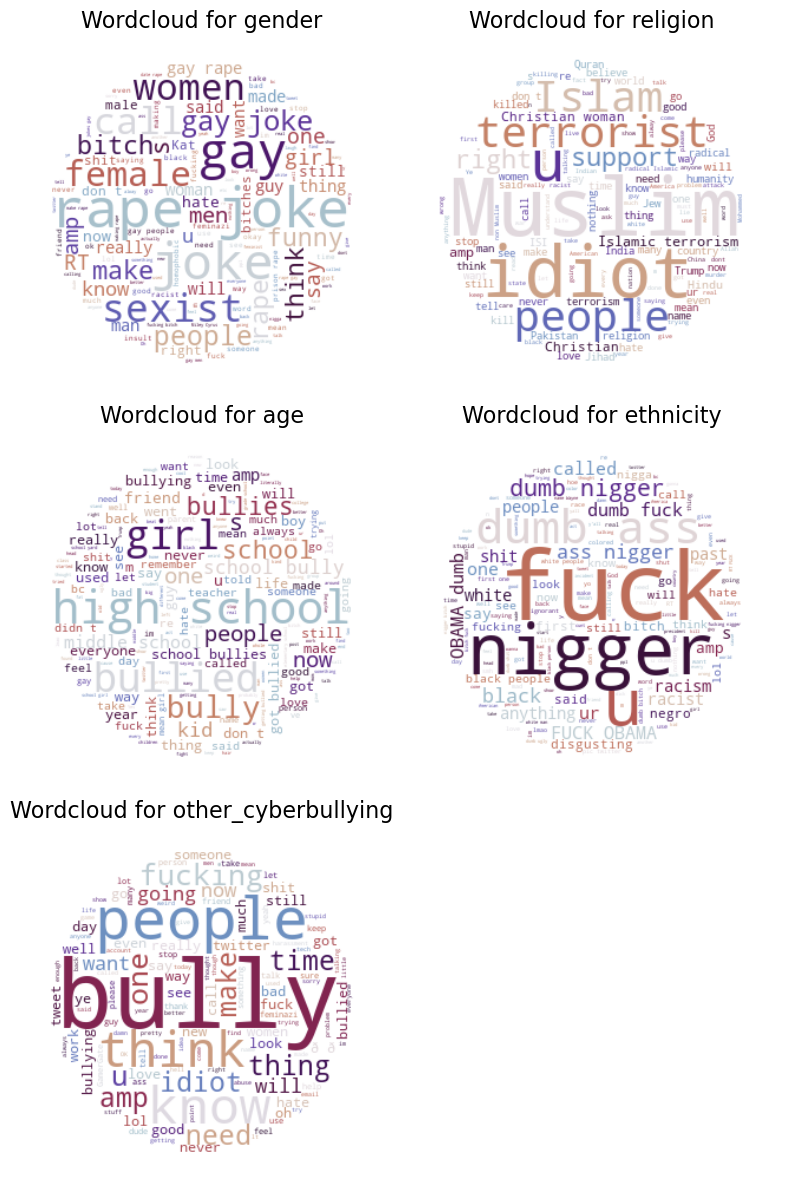

In [322]:
# Mask setup
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# List of cyberbullying types
cyberbullying_types = ['gender', 'religion', 'age', 'ethnicity', 'other_cyberbullying']

# Determine rows and columns for subplots
n_cols = 2  # Number of plots per row
n_rows = -(-len(cyberbullying_types) // n_cols)  # Compute rows with ceiling division

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Generate word clouds for each cyberbullying type
for i, cyber_type in enumerate(cyberbullying_types):
    subclass_df = tweets[tweets['cyberbullying_type'] == cyber_type]
    wordcloud = wc.WordCloud(stopwords=wc.STOPWORDS,
                             max_font_size=80,
                             max_words=1000,
                             width=800,
                             height=800,
                             background_color='white',
                             mask=mask,
                             colormap='twilight').generate(' '.join(subclass_df['text'].dropna()))
    
    # Plot the wordcloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_axis_off()
    axes[i].set_title(f'Wordcloud for {cyber_type}', size=16)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

At last we export data in a new csv to be used

In [323]:
tweets.to_csv('cleantweets.csv')